# Libraries

In [391]:
import math

from pandas import read_csv, unique
import pandas as pd
import numpy as np
from keras import optimizers
from scipy.interpolate import interp1d
from scipy.stats import mode
from scipy import interp
from scipy import stats

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score,roc_auc_score,roc_curve,auc
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.metrics import confusion_matrix

from tensorflow import stack
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling1D, BatchNormalization, MaxPool1D, Reshape, Activation
from keras.layers import Conv1D, LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.callbacks import LearningRateScheduler
from keras.optimizers import SGD

import statsmodels.stats.api as sms

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# Data Load

In [392]:
def read_data(filepath):
    df = read_csv(filepath, header=None, names=['user-id',
                                               'activity',
                                               'timestamp',
                                               'sex',
                                               'age',
                                               'BMI',
                                               'A',
                                               'B',
                                               'C',
                                               'X',
                                               'Y',
                                               'Z'])
    ## removing ';' from last column and converting it to float
    df['Z'].replace(regex=True, inplace=True, to_replace=r';', value=r'')
    df['Z'] = df['Z'].apply(convert_to_float)
#     df.dropna(axis=0, how='any', inplace=True)
    return df

def convert_to_float(x):
    try:
        return np.float64(x)
    except:
        return np.nan

In [393]:
df = read_data('Dataset/Angel_and_Baseline/Angel_data_STS_order.txt')
df

,user-id,activity,timestamp,sex,age,BMI,A,B,C,X,Y,Z
0,1,Yes,0,1,57,24.212293,0.0,38.842979,142.253244,110.183184,132.892332,100.336497
1,1,Yes,1,1,57,24.212293,1.0,39.036722,141.564971,109.963102,132.264821,99.724264
2,1,Yes,2,1,57,24.212293,2.0,39.025532,141.226818,110.076491,131.910252,99.841460
3,1,Yes,3,1,57,24.212293,3.0,39.055731,139.674749,109.314311,130.638475,99.437923
4,1,Yes,4,1,57,24.212293,4.0,39.286753,138.646791,109.321849,129.840633,99.368373
...,...,...,...,...,...,...,...,...,...,...,...,...
142795,357,Yes,395,1,54,25.402816,395.0,53.054386,101.282433,98.437307,91.694820,95.570696
142796,357,Yes,396,1,54,25.402816,396.0,51.566923,104.802220,100.029568,98.373605,98.261446
142797,357,Yes,397,1,54,25.402816,397.0,50.444408,106.489055,101.999649,101.329230,100.532071
142798,357,Yes,398,1,54,25.402816,398.0,50.424259,106.749087,102.629601,101.878083,101.378611


## Label Encoding

In [394]:
label_encode = LabelEncoder()
df['activityEncode'] = label_encode.fit_transform(df['activity'].values.ravel())
df

,user-id,activity,timestamp,sex,age,BMI,A,B,C,X,Y,Z,activityEncode
0,1,Yes,0,1,57,24.212293,0.0,38.842979,142.253244,110.183184,132.892332,100.336497,1
1,1,Yes,1,1,57,24.212293,1.0,39.036722,141.564971,109.963102,132.264821,99.724264,1
2,1,Yes,2,1,57,24.212293,2.0,39.025532,141.226818,110.076491,131.910252,99.841460,1
3,1,Yes,3,1,57,24.212293,3.0,39.055731,139.674749,109.314311,130.638475,99.437923,1
4,1,Yes,4,1,57,24.212293,4.0,39.286753,138.646791,109.321849,129.840633,99.368373,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
142795,357,Yes,395,1,54,25.402816,395.0,53.054386,101.282433,98.437307,91.694820,95.570696,1
142796,357,Yes,396,1,54,25.402816,396.0,51.566923,104.802220,100.029568,98.373605,98.261446,1
142797,357,Yes,397,1,54,25.402816,397.0,50.444408,106.489055,101.999649,101.329230,100.532071,1
142798,357,Yes,398,1,54,25.402816,398.0,50.424259,106.749087,102.629601,101.878083,101.378611,1


## Linear Interpolation

In [395]:
df.isna().sum()

user-id           0
activity          0
timestamp         0
sex               0
age               0
BMI               0
A                 0
B                 0
C                 0
X                 0
Y                 0
Z                 0
activityEncode    0
dtype: int64

In [396]:
interpolation_fn = interp1d(df['activityEncode'] ,df['Z'], kind='linear')
interpolation_fn

In [397]:
null_list = df[df['Z'].isnull()].index.tolist()
null_list

[]

In [398]:
for i in null_list:
    y = df['activityEncode'][i]
    value = interpolation_fn(y)
    df['Z']=df['Z'].fillna(value)
    print(value)

In [399]:
df.isna().sum()

user-id           0
activity          0
timestamp         0
sex               0
age               0
BMI               0
A                 0
B                 0
C                 0
X                 0
Y                 0
Z                 0
activityEncode    0
dtype: int64

## Dataset split

In [400]:
df['age'] = (df['age']-df['age'].min())/(df['age'].max()-df['age'].min())
df['BMI'] = (df['BMI']-df['BMI'].min())/(df['BMI'].max()-df['BMI'].min())
df['A'] = (df['A']-df['A'].min())/(df['A'].max()-df['A'].min())
df['B'] = (df['B']-df['B'].min())/(df['B'].max()-df['B'].min())
df['C'] = (df['C']-df['C'].min())/(df['C'].max()-df['C'].min())
df['X'] = (df['X']-df['X'].min())/(df['X'].max()-df['X'].min())
df['Y'] = (df['Y']-df['Y'].min())/(df['Y'].max()-df['Y'].min())
df['Z'] = (df['Z']-df['Z'].min())/(df['Z'].max()-df['Z'].min())
df['sex'] = (df['sex']-df['sex'].min())/(df['sex'].max()-df['sex'].min())
df

,user-id,activity,timestamp,sex,age,BMI,A,B,C,X,Y,Z,activityEncode
0,1,Yes,0,0.0,0.225806,0.398781,0.000000,0.433618,0.712609,0.423799,0.650296,0.335294,1
1,1,Yes,1,0.0,0.225806,0.398781,0.002506,0.436683,0.707362,0.421885,0.645632,0.329743,1
2,1,Yes,2,0.0,0.225806,0.398781,0.005013,0.436506,0.704784,0.422871,0.642997,0.330805,1
3,1,Yes,3,0.0,0.225806,0.398781,0.007519,0.436984,0.692951,0.416241,0.633544,0.327147,1
4,1,Yes,4,0.0,0.225806,0.398781,0.010025,0.440639,0.685113,0.416307,0.627614,0.326516,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
142795,357,Yes,395,0.0,0.129032,0.460572,0.989975,0.658435,0.400242,0.321626,0.344084,0.292085,1
142796,357,Yes,396,0.0,0.129032,0.460572,0.992481,0.634904,0.427078,0.335476,0.393726,0.316480,1
142797,357,Yes,397,0.0,0.129032,0.460572,0.994987,0.617146,0.439938,0.352614,0.415694,0.337067,1
142798,357,Yes,398,0.0,0.129032,0.460572,0.997494,0.616828,0.441921,0.358093,0.419774,0.344742,1


In [401]:
def segments(df, time_steps, step, label_name):
    N_FEATURES = 9
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['X'].values[i:i+time_steps]
        ys = df['Y'].values[i:i+time_steps]
        zs = df['Z'].values[i:i+time_steps]
        aas = df['A'].values[i:i+time_steps]
        bs = df['B'].values[i:i+time_steps]
        cs = df['C'].values[i:i+time_steps]
        sexs = df['sex'].values[i:i+time_steps]
        ages = df['age'].values[i:i+time_steps]
        bmis = df['BMI'].values[i:i+time_steps]
        label = mode(df[label_name][i:i+time_steps])[0][0]
        segments.append([sexs,ages,bmis,aas,bs,cs,xs, ys, zs])
        labels.append(label)
    reshaped_segments = np.asarray(segments, dtype=np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)
    return reshaped_segments, labels

In [402]:
df

,user-id,activity,timestamp,sex,age,BMI,A,B,C,X,Y,Z,activityEncode
0,1,Yes,0,0.0,0.225806,0.398781,0.000000,0.433618,0.712609,0.423799,0.650296,0.335294,1
1,1,Yes,1,0.0,0.225806,0.398781,0.002506,0.436683,0.707362,0.421885,0.645632,0.329743,1
2,1,Yes,2,0.0,0.225806,0.398781,0.005013,0.436506,0.704784,0.422871,0.642997,0.330805,1
3,1,Yes,3,0.0,0.225806,0.398781,0.007519,0.436984,0.692951,0.416241,0.633544,0.327147,1
4,1,Yes,4,0.0,0.225806,0.398781,0.010025,0.440639,0.685113,0.416307,0.627614,0.326516,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
142795,357,Yes,395,0.0,0.129032,0.460572,0.989975,0.658435,0.400242,0.321626,0.344084,0.292085,1
142796,357,Yes,396,0.0,0.129032,0.460572,0.992481,0.634904,0.427078,0.335476,0.393726,0.316480,1
142797,357,Yes,397,0.0,0.129032,0.460572,0.994987,0.617146,0.439938,0.352614,0.415694,0.337067,1
142798,357,Yes,398,0.0,0.129032,0.460572,0.997494,0.616828,0.441921,0.358093,0.419774,0.344742,1


In [403]:
TIME_PERIOD = 80
STEP_DISTANCE = 40
LABEL = 'activityEncode'

df1=df[df['user-id']>70]
df2=df[df['user-id']>140]
df3=df[df['user-id']>210]
df4=df[df['user-id']>280]

a1=df.shape[0]
b2=df1.shape[0]
c3=df2.shape[0]
d4=df3.shape[0]
e5=df4.shape[0]

df_test0 = df.iloc[0:a1-b2,:]
df_train0 = df.iloc[a1-b2:a1,:]
x_train0, y_train0 = segments(df_train0, TIME_PERIOD, STEP_DISTANCE, LABEL)
x_test0, y_test0 = segments(df_test0, TIME_PERIOD, STEP_DISTANCE, LABEL)
time_period, sensors = x_train0.shape[1], x_train0.shape[2]
num_classes = label_encode.classes_.size
input_shape = time_period * sensors
x_train0 = x_train0.reshape(x_train0.shape[0], input_shape)
x_train0 = x_train0.astype('float32')
y_train0=np.asarray(y_train0).astype('float32').reshape((-1,1))
time_period, sensors = x_test0.shape[1], x_test0.shape[2]
num_classes = label_encode.classes_.size
input_shape = time_period * sensors
x_test0 = x_test0.reshape(x_test0.shape[0], input_shape)
x_test0 = x_test0.astype('float32')
y_test0=np.asarray(y_test0).astype('float32').reshape((-1,1))

df_test1 = df.iloc[a1-b2:a1-c3,:]
df_train1 = pd.concat([df_test0,df.iloc[a1-c3:a1,]])
x_train1, y_train1 = segments(df_train0, TIME_PERIOD, STEP_DISTANCE, LABEL)
x_test1, y_test1 = segments(df_test0, TIME_PERIOD, STEP_DISTANCE, LABEL)
time_period, sensors = x_train1.shape[1], x_train1.shape[2]
num_classes = label_encode.classes_.size
input_shape = time_period * sensors
x_train1 = x_train1.reshape(x_train1.shape[0], input_shape)
x_train1 = x_train1.astype('float32')
y_train1=np.asarray(y_train1).astype('float32').reshape((-1,1))
time_period, sensors = x_test1.shape[1], x_test1.shape[2]
num_classes = label_encode.classes_.size
input_shape = time_period * sensors
x_test1 = x_test1.reshape(x_test1.shape[0], input_shape)
x_test1 = x_test1.astype('float32')
y_test1=np.asarray(y_test1).astype('float32').reshape((-1,1))

df_test2 = df.iloc[a1-c3:a1-d4,:]
df_train2 = pd.concat([df.iloc[0:a1-c3,:],df.iloc[a1-d4:a1,]])
x_train2, y_train2 = segments(df_train0, TIME_PERIOD, STEP_DISTANCE, LABEL)
x_test2, y_test2 = segments(df_test0, TIME_PERIOD, STEP_DISTANCE, LABEL)
time_period, sensors = x_train2.shape[1], x_train2.shape[2]
num_classes = label_encode.classes_.size
input_shape = time_period * sensors
x_train2 = x_train2.reshape(x_train2.shape[0], input_shape)
x_train2 = x_train2.astype('float32')
y_train2=np.asarray(y_train2).astype('float32').reshape((-1,1))
time_period, sensors = x_test2.shape[1], x_test2.shape[2]
num_classes = label_encode.classes_.size
input_shape = time_period * sensors
x_test2 = x_test2.reshape(x_test2.shape[0], input_shape)
x_test2 = x_test2.astype('float32')
y_test2=np.asarray(y_test2).astype('float32').reshape((-1,1))

df_test3 = df.iloc[a1-d4:a1-e5,:]
df_train3 = pd.concat([df.iloc[0:a1-d4,:],df.iloc[a1-e5:a1,]])
x_train3, y_train3 = segments(df_train0, TIME_PERIOD, STEP_DISTANCE, LABEL)
x_test3, y_test3 = segments(df_test0, TIME_PERIOD, STEP_DISTANCE, LABEL)
time_period, sensors = x_train3.shape[1], x_train3.shape[2]
num_classes = label_encode.classes_.size
input_shape = time_period * sensors
x_train3 = x_train3.reshape(x_train3.shape[0], input_shape)
x_train3 = x_train3.astype('float32')
y_train3=np.asarray(y_train3).astype('float32').reshape((-1,1))
time_period, sensors = x_test3.shape[1], x_test3.shape[2]
num_classes = label_encode.classes_.size
input_shape = time_period * sensors
x_test3 = x_test3.reshape(x_test3.shape[0], input_shape)
x_test3 = x_test3.astype('float32')
y_test3=np.asarray(y_test3).astype('float32').reshape((-1,1))

df_test4 = df.iloc[a1-e5:a1,:]
df_train4 = df.iloc[0:a1-e5,:]
x_train4, y_train4 = segments(df_train0, TIME_PERIOD, STEP_DISTANCE, LABEL)
x_test4, y_test4 = segments(df_test0, TIME_PERIOD, STEP_DISTANCE, LABEL)
time_period, sensors = x_train4.shape[1], x_train4.shape[2]
num_classes = label_encode.classes_.size
input_shape = time_period * sensors
x_train4 = x_train4.reshape(x_train4.shape[0], input_shape)
x_train4 = x_train4.astype('float32')
y_train4=np.asarray(y_train4).astype('float32').reshape((-1,1))
time_period, sensors = x_test4.shape[1], x_test4.shape[2]
num_classes = label_encode.classes_.size
input_shape = time_period * sensors
x_test4 = x_test4.reshape(x_test4.shape[0], input_shape)
x_test4 = x_test4.astype('float32')
y_test4=np.asarray(y_test4).astype('float32').reshape((-1,1))


In [404]:
model = Sequential()
model.add(LSTM(32, return_sequences=True, input_shape=(input_shape,1), activation='relu'))
model.add(LSTM(32,return_sequences=True, activation='relu'))
model.add(Reshape((1, 720, 32)))
model.add(Conv1D(filters=64,kernel_size=2, activation='relu', strides=2))
model.add(Reshape((360, 64)))
model.add(MaxPool1D(pool_size=4, padding='same'))
model.add(Conv1D(filters=192, kernel_size=2, activation='relu', strides=1))
model.add(Reshape((89, 192)))
model.add(GlobalAveragePooling1D())
model.add(BatchNormalization(epsilon=1e-06))
model.add(Dense(1))
model.add(Activation('sigmoid'))

print(model.summary())

Model: "sequential_96"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_192 (LSTM)             (None, 720, 32)           4352      
                                                                 
 lstm_193 (LSTM)             (None, 720, 32)           8320      
                                                                 
 reshape_288 (Reshape)       (None, 1, 720, 32)        0         
                                                                 
 conv1d_192 (Conv1D)         (None, 1, 360, 64)        4160      
                                                                 
 reshape_289 (Reshape)       (None, 360, 64)           0         
                                                                 
 max_pooling1d_96 (MaxPoolin  (None, 90, 64)           0         
 g1D)                                                            
                                                     

In [405]:
def get_lr_metric(optimizer):  # printing the value of the learning rate
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr

def step_decay(epoch):
	initial_lrate = 0.0001
	drop = 0.5
	epochs_drop = 5.0
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate
lrate = LearningRateScheduler(step_decay)
sgd = SGD(lr=0.0, momentum=0.9, decay=0.0, nesterov=False)
adam=optimizers.Adam(lr=0.00013, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=0.0, amsgrad=False)
#lr_metric = get_lr_metric(adam)
lr_metric = get_lr_metric(adam)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy',lr_metric])
model1 = Sequential()
model1.add(LSTM(32, return_sequences=True, input_shape=(input_shape,1), activation='relu'))
model1.add(LSTM(32,return_sequences=True, activation='relu'))
model1.add(Reshape((1, 720, 32)))
model1.add(Conv1D(filters=64,kernel_size=2, activation='relu', strides=2))
model1.add(Reshape((360, 64)))
model1.add(MaxPool1D(pool_size=4, padding='same'))
model1.add(Conv1D(filters=192, kernel_size=2, activation='relu', strides=1))
model1.add(Reshape((89, 192)))
model1.add(GlobalAveragePooling1D())
model1.add(BatchNormalization(epsilon=1e-06))
model1.add(Dense(1))
model1.add(Activation('sigmoid'))
model1.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy',lr_metric])

model2 = Sequential()
model2.add(LSTM(32, return_sequences=True, input_shape=(input_shape,1), activation='relu'))
model2.add(LSTM(32,return_sequences=True, activation='relu'))
model2.add(Reshape((1, 720, 32)))
model2.add(Conv1D(filters=64,kernel_size=2, activation='relu', strides=2))
model2.add(Reshape((360, 64)))
model2.add(MaxPool1D(pool_size=4, padding='same'))
model2.add(Conv1D(filters=192, kernel_size=2, activation='relu', strides=1))
model2.add(Reshape((89, 192)))
model2.add(GlobalAveragePooling1D())
model2.add(BatchNormalization(epsilon=1e-06))
model2.add(Dense(1))
model2.add(Activation('sigmoid'))
model2.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy',lr_metric])

model3 = Sequential()
model3.add(LSTM(32, return_sequences=True, input_shape=(input_shape,1), activation='relu'))
model3.add(LSTM(32,return_sequences=True, activation='relu'))
model3.add(Reshape((1, 720, 32)))
model3.add(Conv1D(filters=64,kernel_size=2, activation='relu', strides=2))
model3.add(Reshape((360, 64)))
model3.add(MaxPool1D(pool_size=4, padding='same'))
model3.add(Conv1D(filters=192, kernel_size=2, activation='relu', strides=1))
model3.add(Reshape((89, 192)))
model3.add(GlobalAveragePooling1D())
model3.add(BatchNormalization(epsilon=1e-06))
model3.add(Dense(1))
model3.add(Activation('sigmoid'))
model3.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy',lr_metric])

model4 = Sequential()
model4.add(LSTM(32, return_sequences=True, input_shape=(input_shape,1), activation='relu'))
model4.add(LSTM(32,return_sequences=True, activation='relu'))
model4.add(Reshape((1, 720, 32)))
model4.add(Conv1D(filters=64,kernel_size=2, activation='relu', strides=2))
model4.add(Reshape((360, 64)))
model4.add(MaxPool1D(pool_size=4, padding='same'))
model4.add(Conv1D(filters=192, kernel_size=2, activation='relu', strides=1))
model4.add(Reshape((89, 192)))
model4.add(GlobalAveragePooling1D())
model4.add(BatchNormalization(epsilon=1e-06))
model4.add(Dense(1))
model4.add(Activation('sigmoid'))
model4.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy',lr_metric])

model5 = Sequential()
model5.add(LSTM(32, return_sequences=True, input_shape=(input_shape,1), activation='relu'))
model5.add(LSTM(32,return_sequences=True, activation='relu'))
model5.add(Reshape((1, 720, 32)))
model5.add(Conv1D(filters=64,kernel_size=2, activation='relu', strides=2))
model5.add(Reshape((360, 64)))
model5.add(MaxPool1D(pool_size=4, padding='same'))
model5.add(Conv1D(filters=192, kernel_size=2, activation='relu', strides=1))
model5.add(Reshape((89, 192)))
model5.add(GlobalAveragePooling1D())
model5.add(BatchNormalization(epsilon=1e-06))
model5.add(Dense(1))
model5.add(Activation('sigmoid'))
model5.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy',lr_metric])

In [406]:
scores = []
tprs=[]
mean_fpr=np.linspace(0,1,100)
auck=[0,0,0,0,0]
Recalls=[]
F1score=[]
specificity=[]
accuracys = []
for i in range(5):
    if i==0:
        x_train, y_train = x_train0,y_train0
        x_test, y_test = x_test0,y_test0
        model.fit(x_train, y_train,batch_size=100,epochs=100)
        score = model.evaluate(x_test, y_test)[1]
        scores.append(score)
        fpr, tpr, thresholds = roc_curve(y_test,model.predict(x_test))
        y_pred=model.predict(x_test)
        y_pred = (y_pred >= 0.5)*1  
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        specificity.append(tn / (tn + fp))
        accuracys.append(accuracy_score(y_test, y_pred))
        Recalls.append(metrics.recall_score(y_test, y_pred))
        F1score.append(metrics.f1_score(y_test, y_pred))
    elif i ==1:
        x_train, y_train = x_train1,y_train1
        x_test, y_test = x_test1,y_test1
        model2.fit(x_train, y_train,batch_size=100,epochs=100)
        score = model2.evaluate(x_test, y_test)[1]
        scores.append(score)
        fpr, tpr, thresholds = roc_curve(y_test,model2.predict(x_test))
        y_pred=model2.predict(x_test)
        y_pred = (y_pred >= 0.5)*1  
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        specificity.append(tn / (tn + fp))
        accuracys.append(accuracy_score(y_test, y_pred))
        Recalls.append(metrics.recall_score(y_test, y_pred))
        F1score.append(metrics.f1_score(y_test, y_pred))
    elif i ==2:
        x_train, y_train = x_train2,y_train2
        x_test, y_test = x_test2,y_test2
        model3.fit(x_train, y_train,batch_size=100,epochs=100)
        score = model3.evaluate(x_test, y_test)[1]
        scores.append(score)
        fpr, tpr, thresholds = roc_curve(y_test,model3.predict(x_test))
        y_pred=model3.predict(x_test)
        y_pred = (y_pred >= 0.5)*1  
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        specificity.append(tn / (tn + fp))
        accuracys.append(accuracy_score(y_test, y_pred))
        Recalls.append(metrics.recall_score(y_test, y_pred))
        F1score.append(metrics.f1_score(y_test, y_pred))
    elif i ==3:
        x_train, y_train = x_train3,y_train3
        x_test, y_test = x_test3,y_test3
        model4.fit(x_train, y_train,batch_size=100,epochs=100)
        score = model4.evaluate(x_test, y_test)[1]
        scores.append(score)
        fpr, tpr, thresholds = roc_curve(y_test,model4.predict(x_test))
        y_pred=model4.predict(x_test)
        y_pred = (y_pred >= 0.5)*1  
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        specificity.append(tn / (tn + fp))
        accuracys.append(accuracy_score(y_test, y_pred))
        Recalls.append(metrics.recall_score(y_test, y_pred))
        F1score.append(metrics.f1_score(y_test, y_pred))
    else:
        x_train, y_train = x_train4,y_train4
        x_test, y_test = x_test4,y_test4
        model5.fit(x_train, y_train,batch_size=100,epochs=100)
        score = model5.evaluate(x_test, y_test)[1]
        scores.append(score)
        fpr, tpr, thresholds = roc_curve(y_test,model5.predict(x_test))
        y_pred=model5.predict(x_test)
        y_pred = (y_pred >= 0.5)*1  
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        specificity.append(tn / (tn + fp))
        accuracys.append(accuracy_score(y_test, y_pred))
        Recalls.append(metrics.recall_score(y_test, y_pred))
        F1score.append(metrics.f1_score(y_test, y_pred))
    auck[i] = auc(fpr, tpr)
    tprs.append(interp(mean_fpr,fpr,tpr))
    tprs[-1][0]=0.0
scores=np.array(scores)
interval = stats.t.interval(0.95, scores.shape[0] - 1, scores.mean(), scores.std() / np.sqrt(scores.shape[0]))

Epoch 1/100
29/29 [==============================] - 11s 328ms/step - loss: 0.6388 - accuracy: 0.6363 - lr: 1.3000e-04
Epoch 2/100
29/29 [==============================] - 9s 312ms/step - loss: 0.5812 - accuracy: 0.6970 - lr: 1.3000e-04
Epoch 3/100
29/29 [==============================] - 9s 311ms/step - loss: 0.5434 - accuracy: 0.7326 - lr: 1.3000e-04
Epoch 4/100
29/29 [==============================] - 9s 314ms/step - loss: 0.5176 - accuracy: 0.7556 - lr: 1.3000e-04
Epoch 5/100
29/29 [==============================] - 9s 312ms/step - loss: 0.4965 - accuracy: 0.7632 - lr: 1.3000e-04
Epoch 6/100
29/29 [==============================] - 9s 313ms/step - loss: 0.4743 - accuracy: 0.7765 - lr: 1.3000e-04
Epoch 7/100
29/29 [==============================] - 9s 311ms/step - loss: 0.4554 - accuracy: 0.7901 - lr: 1.3000e-04
Epoch 8/100
29/29 [==============================] - 9s 315ms/step - loss: 0.4392 - accuracy: 0.8054 - lr: 1.3000e-04
Epoch 9/100
29/29 [==============================] - 9s

In [407]:
print("confidence interval：{}".format(interval))
print('scores:',np.mean(scores))
print('AUC:',np.mean(auck))

confidence interval：(0.8089189036973181, 0.9670123354307947)
scores: 0.8879656195640564
AUC: 0.9812154591566357


In [410]:
print('Accuracys:',np.mean(accuracys))

Accuracys: 0.8879656160458452


In [411]:
print('Recalls:',np.mean(Recalls))
print('F1score:',np.mean(F1score))

Recalls: 0.9495798319327731
F1score: 0.9228376311709312


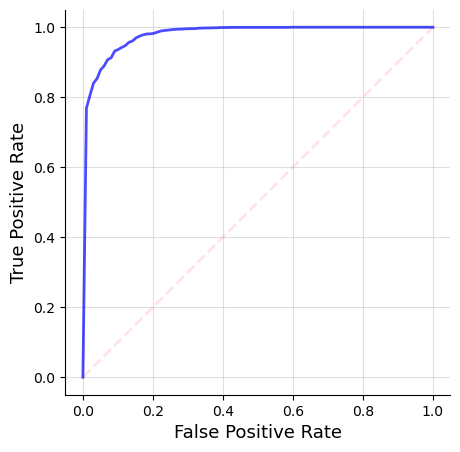

In [415]:
plt.figure(figsize=(5,5))
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.grid(alpha=0.4)

ax = plt.gca()
ax.set_aspect(1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.plot([0,1],[0,1],linestyle='--',lw=2,color='r',alpha=0.1)
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=13)
mean_tpr=np.mean(tprs,axis=0)
mean_tpr[-1]=1.0
std_auc=np.std(tprs,axis=0)
plt.plot(mean_fpr,mean_tpr,color='b',label = u'AUC=%.3f' % (sum(auck)/5),lw=2,alpha=0.7)